<a href="https://colab.research.google.com/github/rmogi/MNIST/blob/mnist_source-code/MNIST_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

sns.set(style='white', context='notebook', palette='deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install -q efficientnet

import efficientnet.tfkeras as efn

     |████████████████████████████████| 51kB 2.4MB/s 


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
# データの読み込み
train = pd.read_csv("/content/drive/My Drive/digit-recognizer/train.csv")
test = pd.read_csv("/content/drive/My Drive/digit-recognizer/test.csv")

print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [6]:
y_train = train["label"]

x_train = train.drop(labels = ["label"],axis = 1) 

In [7]:
y_train = train['label'].values.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [8]:
x_train = train.drop(labels=['label'], axis=1)
x_train.shape

(42000, 784)

In [9]:
x_train = x_train.astype('float32')
x_train = x_train / 255

In [10]:
x_train = x_train.values.reshape(42000,28,28,1)
x_train.shape

(42000, 28, 28, 1)

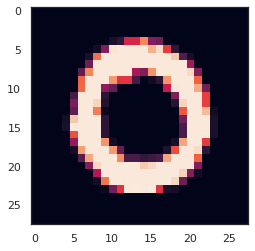

In [11]:
plt.imshow(x_train[1][:,:,0]) 

In [12]:
x_train = np.pad(x_train, ((0,0), (2,2), (2,2), (0,0)), mode='constant')
x_train.shape

(42000, 32, 32, 1)

In [13]:
x_train = np.squeeze(x_train, axis=-1)
x_train = stacked_img = np.stack((x_train,)*3, axis=-1)
x_train.shape

(42000, 32, 32, 3)

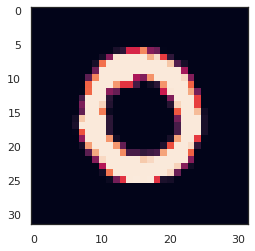

In [14]:
plt.imshow(x_train[1][:,:,0])

In [15]:
def create_model():
    enet = efn.EfficientNetB3(
    input_shape=(32, 32, 3),
    weights='imagenet',
    include_top=False,
    )        
    
    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    return model

In [16]:
with strategy.scope():
  model = create_model()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

44113920/44107200 [==============================] - 4s 0us/step


In [17]:
%%time

model.fit(
    x_train, y_train,
    epochs=3,
    batch_size = 210,
    shuffle=True,
    verbose = 1
)

Epoch 1/3
200/200 [==============================] - 1140s 6s/step - loss: 0.2679 - accuracy: 0.9170
Epoch 2/3
200/200 [==============================] - 1134s 6s/step - loss: 0.0592 - accuracy: 0.9838
Epoch 3/3
200/200 [==============================] - 1131s 6s/step - loss: 0.0408 - accuracy: 0.9888
CPU times: user 1h 23min 19s, sys: 1min 17s, total: 1h 24min 36s
Wall time: 57min 14s


In [20]:
test = test.astype('float32')
test = test / 255
test = test.values.reshape(len(test),28,28,1)
test = np.pad(test, ((0,0), (2,2), (2,2), (0,0)), mode='constant')
test = np.squeeze(test, axis=-1)
test = stacked_img = np.stack((test,)*3, axis=-1)
test.shape

(28000, 32, 32, 3)

In [21]:
%%time

test_predictions = model.predict(test)

CPU times: user 2min 21s, sys: 6.37 s, total: 2min 27s
Wall time: 1min 27s


In [22]:
results = np.argmax(test_predictions,axis = 1)
results = pd.Series(results,name="Label")

In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST_EfficientNet.csv",index=False)

submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
